In [1]:
import os

import ase.io
import ase.atoms
import scipy.stats
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.style.use('seaborn-v0_8')

### Single particle loading for experiments: 

In [2]:
particle = ase.io.read(os.path.join('..', 'data', 'S_random_1.xyz'))
particle

Atoms(symbols='Au10SCH2C4H2C2H2C4H2CSAu10', pbc=False)

In [3]:
def load_lines_after_specified_one(path: str, specified_line: str):
    comments = []
    next_line_is_comment = False

    with open(path) as f:
        for line in f:
            if next_line_is_comment:
                comments.append(line.strip())
            next_line_is_comment = (line == specified_line)
    return comments      
       
comments = load_lines_after_specified_one(
    os.path.join("..", "data", "S_random_8000.xyz"), 
    "42\n"
) 
y = pd.read_csv(os.path.join('..', 'data', 'S_random_8000.trans'), header=None)[0]  

In [4]:
# 1. siarka - odłegość między nimi
sulfur_idxes = [10, 31]
# 2. benzeny odległość między środkami
benzene1_idxes = [11, 14, 15, 16, 17, 20]
benzene2_idxes = [21, 24, 25, 26, 27, 30]
# 3. kąt skręcenia benzenów - skręcają się tylko na osi wiązania między 21 a 22 (z obrazka)
benzene1_plane_idxes = [14, 15, 16]   # oba przypadki to V-ki zaczynające się od prawego górenego rogu, potem dolny i potem lewy gorny
benzene2_plane_idxes = [25, 26, 27]
# 4.  kąty międy jakimiś parami atomów Au-S-C, czy C-C-C, może wybór genetyczny?
Au_S_C_idxes_1 = [32, 31, 30]
Au_S_C_idxes_2 = [9, 10, 11]
Au_Au_S_idxes_1 = [33, 32, 31]
Au_Au_S_idxes_2 = [33, 32, 31]
Au_C_Au_idxes = [32, 21, 9]
H_C_H_idxes = [20, 22, 23]
# 5. wyciągnąć dane ze stinga informacyjnego
"""
U nas komentarz to jest długi i zawiera (wszystkie ramki powinny mieć
komentarz składający się z tej samej liczby pól)
* id struktury (one nie muszą być unikane!) - to trzeba zignorować
* energia całkowita (też raczej nieistotna bo nie ma korelacji między
transportem i energią)
* poziom Fermiego
* 1
* poziomy energetyczne (=wartości własne równania Schrodinger)
* obsadzenia stanów (to są prawie same 1 i 0 ale przeważnie 2 obsadzenia
są ułamkowe: z tego można wyczytać stany HOMO i LUMO. Obsadzenia są
ułamkowe bo elektronika w DFT jest sztucznie rozmywana żeby zapewnić
zbieżność).
""";


In [5]:

    
# 1.
def get_particle_symbols(particle, *idxes):
    return [particle.get_chemical_symbols()[idx] for idx in idxes]
 
 
def generate_feature_id(particle, *idxes):
    symbols = get_particle_symbols(particle, *idxes)
    return "".join([f"{s}{idx}" for s, idx in zip(symbols, idxes)])
 
    
def add_dst_feature(df, idx1, idx2):
    particle = df.loc[0, 'obj']
    feature_name = f"dst{generate_feature_id(particle, idx1, idx2)}"
    df[feature_name] = df['obj'].apply(lambda p: p.get_distance(idx1, idx2))
     
# 2.
def get_benzine_dst(particle, benzene1_idxes, benzene2_idxes):
    benzene1_center = np.mean(particle.positions[benzene1_idxes], axis=0)
    benzene2_center = np.mean(particle.positions[benzene2_idxes], axis=0)
    return np.linalg.norm(benzene1_center - benzene2_center)

# 3.

#   kąt między wektorami
def unit_vector(vector):
    """ Returns the unit vector of the vector.  """
    return vector / np.linalg.norm(vector)


def angle_between(v1, v2):
    """ Returns the angle in radians between vectors 'v1' and 'v2'::

            >>> angle_between((1, 0, 0), (0, 1, 0))
            1.5707963267948966
            >>> angle_between((1, 0, 0), (1, 0, 0))
            0.0
            >>> angle_between((1, 0, 0), (-1, 0, 0))
            3.141592653589793
    """
    v1_u = unit_vector(v1)
    v2_u = unit_vector(v2)
    return np.arccos(np.clip(np.dot(v1_u, v2_u), -1.0, 1.0))


def calculate_normal_vector(particle, plane_idxes):
    idx_0, idx_1, idx_2 = plane_idxes
    v1 = particle.positions[idx_0] - particle.positions[idx_1]
    v2 = particle.positions[idx_2] - particle.positions[idx_1]
    return np.cross(v1, v2)

def angle_between_planes(particle, plane1_idxes, plane2_idxes):
    normal_vec1 = calculate_normal_vector(particle, plane1_idxes)
    normal_vec2 = calculate_normal_vector(particle, plane2_idxes)
    return angle_between(normal_vec1, normal_vec2)



# 4.
def add_angle_feature(df, idx1, idx2, idx3):
    particle = df.loc[0, 'obj']
    feature_name = f"ang{generate_feature_id(particle, idx1, idx2, idx3)}"
    df[feature_name] = df['obj'].apply(lambda p: p.get_angle(idx1, idx2, idx3))
    
    
def add_dihedral_feature(df, idx1, idx2, idx3, idx4):
    particle = df.loc[0, 'obj']
    feature_name = f"dih{generate_feature_id(particle, idx1, idx2, idx3, idx4)}"
    df[feature_name] = df['obj'].apply(lambda p: p.get_dihedral(idx1, idx2, idx3, idx4))
    
# 5.


def get_comments_df(file_path):
    comments = load_lines_after_specified_one(
        file_path, 
        "42\n"
    )
    comments_df = pd.Series(comments).str.split(expand=True).astype(float)

    column_names = (['id', 'total_energy', 'fermi_energy', '1'] 
               + [f"energy_level_{i}" for i in range(140-4)]
               + [f"electron_state_{i}" for i in range(len(comments_df.columns)-140)])
    comments_df.columns = column_names
    return comments_df


In [6]:

# from_file = '10841    -20359.370698957        -0.888261594   1  -18.41187  -17.87553  -16.42974  -15.98278  -15.74703  -15.35626  -13.85950  -13.13731  -13.03603  -12.33922  -12.09635  -11.67449  -10.32082   -9.40646   -8.91820   -8.67743   -8.59578   -8.50151   -8.42974   -8.13734   -7.90310   -7.85150   -7.81116   -7.72296   -7.68616   -7.62065   -7.55496   -7.49044   -7.18377   -7.14342   -7.09385   -7.07617   -6.96080   -6.90188   -6.84310   -6.66938   -6.52952   -6.48857   -6.46624   -6.43404   -6.37009   -6.36173   -6.33250   -6.29974   -6.28557   -6.25814   -6.23566   -6.22080   -6.20709   -6.16873   -6.15508   -6.09262   -6.07727   -6.06650   -6.02008   -5.94643   -5.92104   -5.85158   -5.77577   -5.74555   -5.74149   -5.63554   -5.61896   -5.56070   -5.50060   -5.47401   -5.41656   -5.37772   -5.34222   -5.31684   -5.27117   -5.22906   -5.21348   -5.14051   -5.11293   -5.07553   -5.06478   -5.04245   -4.96359   -4.94582   -4.89002   -4.83924   -4.81783   -4.77144   -4.76854   -4.74907   -4.72153   -4.70618   -4.68249   -4.63994   -4.62529   -4.61364   -4.58455   -4.56793   -4.53308   -4.50069   -4.49322   -4.48171   -4.41211   -4.40027   -4.37482   -4.37459   -4.33364   -4.31268   -4.30102   -4.26972   -4.26486   -4.24142   -4.21201   -4.17203   -4.12158   -4.07418   -4.04482   -4.02809   -3.88556   -3.85695   -3.82291   -3.81570   -3.80829   -3.72008   -3.69482   -3.68926   -3.66995   -3.66624   -3.64801   -3.60913   -3.58440   -3.55238   -3.53259   -3.52187   -3.44201   -3.33704   -3.30929   -3.25251   -3.22459   -3.21281 1.0000000 1.0000000 1.0000000 1.0000000 1.0000000 1.0000000 1.0000000 1.0000000 1.0000000 1.0000000 1.0000000 1.0000000 1.0000000 1.0000000 1.0000000 1.0000000 1.0000000 1.0000000 1.0000000 1.0000000 1.0000000 1.0000000 1.0000000 1.0000000 1.0000000 1.0000000 1.0000000 1.0000000 1.0000000 1.0000000 1.0000000 1.0000000 1.0000000 1.0000000 1.0000000 1.0000000 1.0000000 1.0000000 1.0000000 1.0000000 1.0000000 1.0000000 1.0000000 1.0000000 1.0000000 1.0000000 1.0000000 1.0000000 1.0000000 1.0000000 1.0000000 1.0000000 1.0000000 1.0000000 1.0000000 1.0000000 1.0000000 1.0000000 1.0000000 1.0000000 1.0000000 1.0000000 1.0000000 1.0000000 1.0000000 1.0000000 1.0000000 1.0000000 1.0000000 1.0000000 1.0000000 1.0000000 1.0000000 1.0000000 1.0000000 1.0000000 1.0000000 1.0000000 1.0000000 1.0000000 1.0000000 1.0000000 1.0000000 1.0000000 1.0000000 1.0000000 1.0000000 1.0000000 1.0000000 1.0000000 1.0000000 1.0000000 1.0000000 1.0000000 1.0000000 1.0000000 1.0000000 1.0000000 1.0000000 1.0000000 1.0000000 1.0000000 1.0000000 1.0000000 1.0000000 1.0000000 1.0000000 1.0000000 1.0000000 1.0000000 1.0000000 1.0000000 1.0000000 1.0000000 1.0000000 1.0000000 1.0000000 1.0000000 1.0000000 1.0000000 1.0000000 1.0000000 1.0000000 1.0000000 1.0000000 1.0000000 1.0000000 1.0000000 1.0000000 1.0000000 1.0000000 1.0000000 1.0000000 1.0000000 1.0000000 1.0000000 1.0000000 1.0000000 1.0000000 1.0000000 1.0000000 1.0000000 1.0000000 0.5141006 0.4858994 0.0000000 0.0000000 0.0000000 0.0000000 0.0000000'
# from_file = pd.Series(map(float, from_file.split()))
# from_atoms = pd.Series(list(xyz.info.keys()) + list(xyz.info.values()))
        

# df = pd.concat([from_file, from_atoms], axis=1)
# df.columns = ["from_file", "from_atoms"]
# df = df.applymap(float)
# from_file.size, from_atoms.size # -> (290, 144)
# df[(df["from_file"] != df["from_atoms"])]


# Apply to all particles:

In [7]:
df = pd.DataFrame({
    'obj': ase.io.iread(os.path.join('..', 'data', 'S_random_8000.xyz')),
    'y': pd.read_csv(os.path.join('..', 'data', 'S_random_8000.trans'), header=None)[0]  
})
df.head()


,obj,y
0,"(Atom('Au', [-2.8495, -1.4991, -4.7542], index...",0.053781
1,"(Atom('Au', [-2.6438, -1.4196, -4.8078], index...",0.020805
2,"(Atom('Au', [-2.554, -1.4182, -4.7647], index=...",0.040863
3,"(Atom('Au', [-2.6611, -1.3871, -4.8366], index...",0.018621
4,"(Atom('Au', [-2.7049, -1.5004, -4.7819], index...",0.070293


In [8]:
# 1

add_dst_feature(df, *sulfur_idxes)
add_dst_feature(df, 32, 9) # AuAu33_10
add_dst_feature(df, 20, 21) # CC21_22
add_dst_feature(df, 31, 32) # SAu32_33
add_dst_feature(df, 32, 33) # Au-Au (np. 33-34)
add_dst_feature(df, 30, 31) # C-S (np. 31-32)
add_dst_feature(df, 27, 29) # C-H (np. 28-30)
add_dst_feature(df, 15, 17) # C-C w pierścieniach benzenu (np. 16-18)

# 2
df['benzine_dst'] = df['obj'].apply(
    lambda particle: 
        get_benzine_dst(particle, benzene1_idxes, benzene2_idxes)
)


# ask: czy jest istotne jak wybieramy indeksy beneznow które rozpinają płaszczyznę (czy benzen jest płaski)
# 3
df['benzines_angle'] = df['obj'].apply(
    lambda particle: 
        angle_between_planes(particle, benzene1_plane_idxes, benzene2_plane_idxes)
)

# 4
add_angle_feature(df, *Au_S_C_idxes_1)
add_angle_feature(df, *Au_S_C_idxes_2)
add_angle_feature(df, *Au_Au_S_idxes_1)
add_angle_feature(df, *Au_C_Au_idxes)
add_angle_feature(df, *H_C_H_idxes)

add_angle_feature(df, 21, 24, 26) # C-C-C (np. 22-25-27)
add_angle_feature(df, 24, 25, 27) # H-C-C (np. 24-26-28)
add_angle_feature(df, 27, 30, 31) # C-C-S (np. 28-31-32)
add_angle_feature(df, 31, 33, 35) # Au-Au-Au (33-34-36)

add_dihedral_feature(df, 32, 31, 30, 26) # kąt torsyjny Au-S-C-C (np. 33-32-31-27)
add_dihedral_feature(df, 7, 9, 10, 11) # kąt torsyjny Au-Au-S-C (np. 8-10-11-12)

# 5

# ask: czy warto wybierać coś więcej niż homo-lumo
# ask: czy dobrze wybieramy homo-lumo diff

comments_df = get_comments_df(os.path.join("..", "data", "S_random_8000.xyz"))
df["HOMO_LUMO_diff"] = comments_df["energy_level_130"] - comments_df["energy_level_131"]
df['fermi_energy'] = comments_df['fermi_energy']
df['total_energy'] = comments_df['total_energy']
df.head()

,obj,y,dstS10S31,dstAu32Au9,dstC20C21,dstS31Au32,dstAu32Au33,dstC30S31,dstC27H29,dstC15C17,...,angC20H22H23,angC21C24C26,angC24C25C27,angC27C30S31,angS31Au33Au35,dihAu32S31C30C26,dihAu7Au9S10C11,HOMO_LUMO_diff,fermi_energy,total_energy
0,"(Atom('Au', [-2.8495, -1.4991, -4.7542], index...",0.053781,10.912339,13.434613,1.534270,2.354064,2.640687,1.832045,1.083721,1.400757,...,37.866900,124.086495,91.959114,117.513640,80.706329,9.483020,102.454852,-0.10497,-0.888262,-20359.370699
1,"(Atom('Au', [-2.6438, -1.4196, -4.8078], index...",0.020805,10.964204,13.549083,1.550660,2.316071,2.669263,1.867895,1.083701,1.443852,...,39.097625,121.025577,91.247755,116.391907,76.887384,336.267060,118.500587,-0.09747,-0.875313,-20359.369666
2,"(Atom('Au', [-2.554, -1.4182, -4.7647], index=...",0.040863,10.918358,13.495637,1.517179,2.303027,2.636651,1.824826,1.083686,1.395589,...,39.139238,121.244677,89.581746,116.136655,70.944981,35.329027,111.063045,-0.10305,-0.860178,-20359.228060
3,"(Atom('Au', [-2.6611, -1.3871, -4.8366], index...",0.018621,10.984311,13.531119,1.514910,2.304654,2.621340,1.866742,1.083674,1.436434,...,38.252945,122.810631,89.659731,117.082562,56.257350,348.227353,237.726343,-0.14497,-0.823416,-20359.205744
4,"(Atom('Au', [-2.7049, -1.5004, -4.7819], index...",0.070293,10.989901,13.573948,1.537912,2.318414,2.681990,1.807603,1.083700,1.420207,...,39.973621,121.186832,90.104363,118.660694,53.386743,19.309055,248.336134,-0.10902,-0.817940,-20359.260510


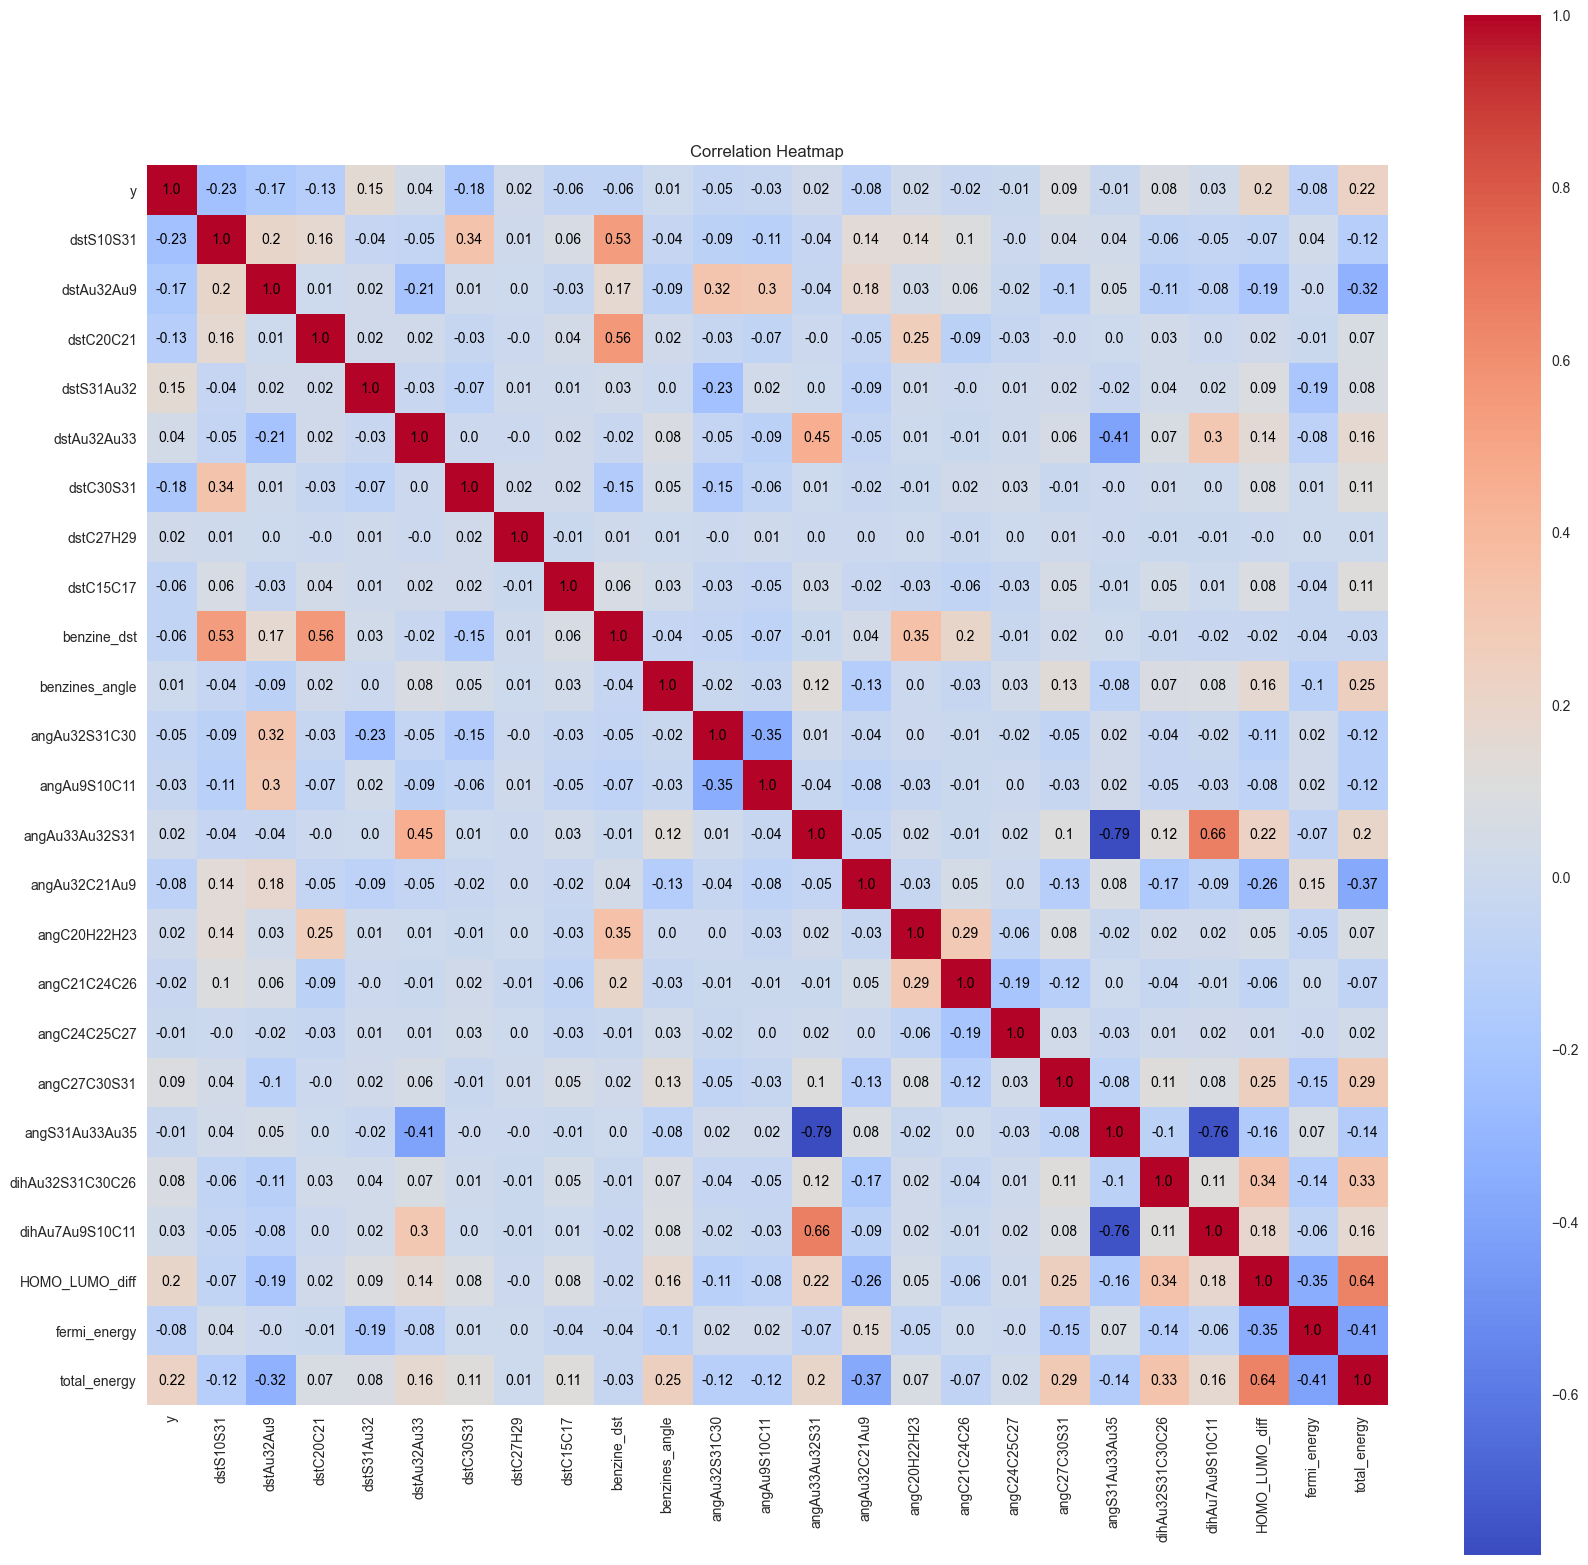

In [9]:
corr_matrix = (
    df
    .drop('obj', axis=1)
    .corr(numeric_only=False)
)
# plot a heatmap of the correlation matrix
fig, ax = plt.subplots()
fig.set_size_inches(20, 20)
im = ax.imshow(corr_matrix.values, cmap='coolwarm')

# add the column names as tick labels
ax.set_xticks(range(len(corr_matrix.columns)))
ax.set_yticks(range(len(corr_matrix.columns)))
ax.set_xticklabels(corr_matrix.columns, rotation=90)
ax.set_yticklabels(corr_matrix.columns)

plt.grid(False)

# add the correlation coefficients as text annotations
for i in range(len(corr_matrix.columns)):
    for j in range(len(corr_matrix.columns)):
        text = ax.text(j, i, round(corr_matrix.values[i, j], 2),
                       ha="center", va="center", color="black")

# add a color bar
cbar = ax.figure.colorbar(im, ax=ax)

# set the title and show the plot
ax.set_title("Correlation Heatmap")
plt.show()

In [10]:
corr_treshold = 0.00
restricted_features = corr_matrix[corr_matrix["y"].abs()>=corr_treshold].index[1:]

# Trening

In [11]:
import sklearn.model_selection # train test split
import sklearn.ensemble # GradientBoostingRegressor
import sklearn.metrics # mean_squared_error

seed = 0xCAFFE

y = df['y']
# X = df.drop(['y', 'obj'], axis=1)
X = df[restricted_features]


y.shape, X.shape

((8000,), (8000, 24))

In [12]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(
    X, y, test_size=0.25, random_state=seed
)
for x in [X_train, X_test, y_train, y_test]:
    print(x.shape)

(6000, 24)
(2000, 24)
(6000,)
(2000,)


In [13]:
clf = sklearn.ensemble.GradientBoostingRegressor(
    learning_rate=0.25, max_depth=3, n_estimators=100, random_state=seed
 )
# clf = sklearn.ensemble.RandomForestRegressor(
#     n_estimators=100, 
#     max_depth=None, 
#     min_samples_split=2, 
#     min_samples_leaf=1, 
#     max_features='auto', 
#     bootstrap=True,
#     random_state=seed,
# )
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
mse = sklearn.metrics.mean_squared_error(y_test, y_pred)
rmse = sklearn.metrics.mean_squared_error(y_test, y_pred, squared=False)
mae = sklearn.metrics.mean_absolute_error(y_test, y_pred)
mape = sklearn.metrics.mean_absolute_percentage_error(y_test, y_pred)

print("MSE:", mse, "\nRMSE:", rmse, "\nMAE:", mae, "\nMAPE:", mape)


MSE: 0.0011300077997781384 
RMSE: 0.03361558864244591 
MAE: 0.022594999716348676 
MAPE: 0.5992705174113218


0.024895454995562134
0.018987293341685942 0.037566819097071366


<Axes: xlabel='y_test', ylabel='y_pred'>

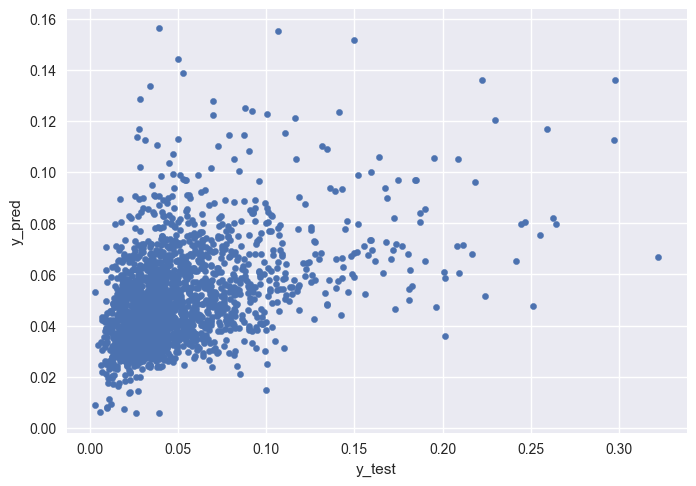

In [21]:
# plt.bar(range(len(y_test)), sorted(list(y_test - y_pred)))
results_df = pd.DataFrame({
    'y_test': y_test,
    'y_pred': y_pred,
    'diff': y_test-y_pred
})
print(results_df["diff"].abs().std())
print(y_pred.std(), y_test.std())
results_df.sort_values('y_test')[['y_test', 'y_pred']].plot.scatter('y_test', 'y_pred')

<Axes: >

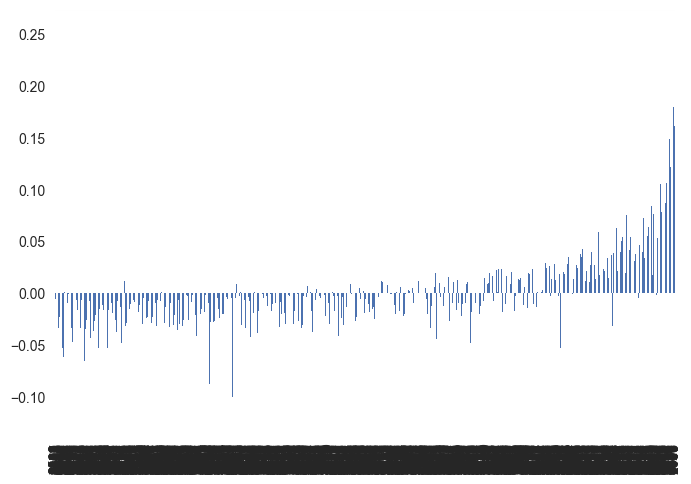

In [26]:
results_df.sort_values('y_test')['diff'].plot.bar()


In [15]:
y_test.mean()

0.049962045597

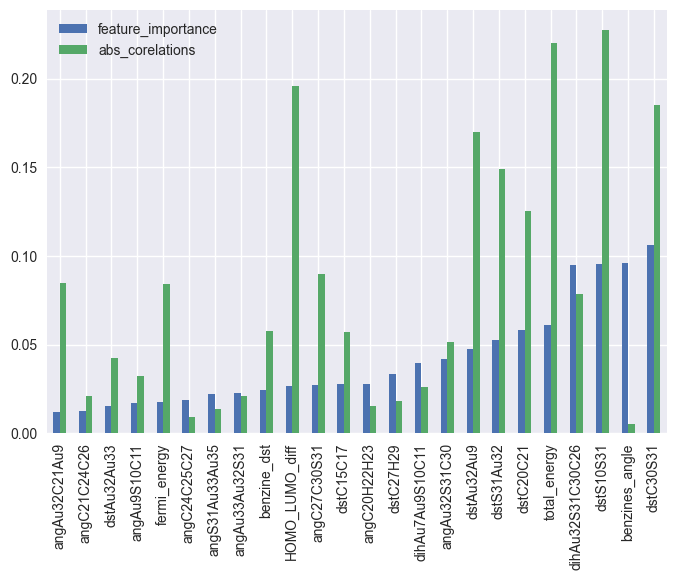

In [16]:
abs_correlations = corr_matrix.loc["y", corr_matrix["y"].abs()>=corr_treshold].abs().rename("abs_corelations")
features_importance = pd.Series(clf.feature_importances_, index=restricted_features).rename("feature_importance")

importance_df = pd.merge(features_importance, abs_correlations, left_index=True, right_index=True)
importance_df.sort_values("feature_importance").plot.bar()
plt.show()

# ask: energia całkowita jest bardziej skorelowana i bardziej istotna dla modelu niż poziom fermiego

# Grid Search for complex analise

In [17]:
# from sklearn.model_selection import GridSearchCV

# # create a GradientBoostingRegressor object
# clf = sklearn.ensemble.GradientBoostingRegressor()

# # define the hyperparameter grid to search over
# param_grid = {
#     'learning_rate': [0.25, 0.1, 0.05, 0.01, 0.001],
#     'n_estimators': [50],
#     'max_depth': [3, 5, 7, 9]
# }

# # define the grid search object
# grid_search = GridSearchCV(clf, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error')

# # fit the grid search object to the data
# grid_search.fit(X, y)

# # print the best hyperparameters and the corresponding mean squared error
# print("Best hyperparameters: ", grid_search.best_params_)
# print("Best MSE: ", abs(grid_search.best_score_))

# # predict on the test data using the best model
# best_model = grid_search.best_estimator_
# y_pred = best_model.predict(X_test)

# mse = sklearn.metrics.mean_squared_error(y_test, y_pred)
# rmse = sklearn.metrics.mean_squared_error(y_test, y_pred, squared=False)
# mae = sklearn.metrics.mean_absolute_error(y_test, y_pred)
# mape = sklearn.metrics.mean_absolute_percentage_error(y_test, y_pred)

# print("\nMSE:", mse, "\nRMSE:", rmse, "\nMAE:", mae, "\nMAPE:", mape)

